In [1]:
%pylab inline
import pandas as pd
import datetime
import matplotlib.dates as mdates

Populating the interactive namespace from numpy and matplotlib


# Data Inspection

In [2]:
df = pd.read_csv('data')

In [3]:
df.shape

(464237, 9)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 464237 entries, 0 to 464236
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   time    464237 non-null  int64 
 1   symbol  464237 non-null  object
 2   bid     464237 non-null  int64 
 3   bidsz   464237 non-null  int64 
 4   ask     464237 non-null  int64 
 5   asksz   464237 non-null  int64 
 6   trdsz   464237 non-null  int64 
 7   trdsd   464237 non-null  int64 
 8   trdpx   464237 non-null  int64 
dtypes: int64(8), object(1)
memory usage: 31.9+ MB


In [5]:
df

,time,symbol,bid,bidsz,ask,asksz,trdsz,trdsd,trdpx
0,1800019613,STOCKB,9063,3,9125,3,0,0,0
1,1800019697,STOCKB,9063,3,9125,3,0,0,0
2,1800022475,STOCKB,9063,3,9125,3,0,0,0
3,1800022582,STOCKB,9063,3,9125,3,0,0,0
4,1800028514,STOCKB,9063,3,9125,3,0,0,0
...,...,...,...,...,...,...,...,...,...
464232,25199657491,STOCKB,9118,27,9119,25,0,0,0
464233,25199685337,STOCKB,9118,27,9119,26,0,0,0
464234,25199693593,STOCKB,9118,27,9119,26,0,0,0
464235,25199694171,STOCKA,4149,47,4150,103,0,0,0


Process time. The time is in us. The trading time starts at 9:30am and ends at 4pm

In [6]:
df['datetime'] = pd.to_datetime(df['time'], unit='us')
df['datetime'] += pd.Timedelta(hours=9)

Check for duplicated rows.

In [7]:
df[df.duplicated(keep=False)]

,time,symbol,bid,bidsz,ask,asksz,trdsz,trdsd,trdpx,datetime
16,1800202398,STOCKB,9063,3,9125,6,0,0,0,1970-01-01 09:30:00.202398
17,1800202398,STOCKB,9063,3,9125,6,0,0,0,1970-01-01 09:30:00.202398
18,1800202398,STOCKB,9063,3,9125,6,0,0,0,1970-01-01 09:30:00.202398
19,1800202398,STOCKB,9063,3,9125,6,0,0,0,1970-01-01 09:30:00.202398
20,1800202398,STOCKB,9063,3,9125,6,0,0,0,1970-01-01 09:30:00.202398
...,...,...,...,...,...,...,...,...,...,...
464218,25199357310,STOCKB,9118,27,9119,25,0,0,0,1970-01-01 15:59:59.357310
464219,25199357310,STOCKB,9118,27,9119,25,0,0,0,1970-01-01 15:59:59.357310
464227,25199489286,STOCKA,4149,49,4150,104,0,0,0,1970-01-01 15:59:59.489286
464228,25199489286,STOCKA,4149,49,4150,104,0,0,0,1970-01-01 15:59:59.489286


In [8]:
sum(df[df.duplicated(keep=False)]['trdsz']!=0)

7847

There are lots of duplicates, the sampling frequency of the data is higher than one-per-us sometimes.

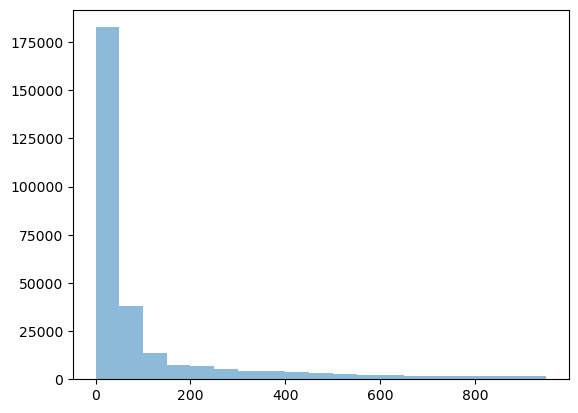

In [9]:
hist(df.time.diff(),bins = np.arange(0,1000,50),alpha = 0.5);

The inconsistent timestamps indicate that we will need to resample the data.

Since the question did not state a clear objective of what price to predict, I will define the time resolution and prediction horizon to be 30s.

In [10]:
interval = pd.Timedelta(seconds = 1)
df['time_id'] = ((df['datetime'] - df['datetime'].min()) // interval).astype(int)

Separate data into order book data and transaction data for stock A and B

In [11]:
df_A_OrderBook = df[(df.symbol=="STOCKA") & (df.bid!=0)]
df_B_OrderBook = df[(df.symbol=="STOCKB") & (df.bid!=0)]
df_A_trade = df[(df.symbol=="STOCKA") & (df.bid==0)]
df_B_trade = df[(df.symbol=="STOCKB") & (df.bid==0)]
print("Count of data")
print("Stock A book:",len(df_A_OrderBook))
print("Stock B book:",len(df_B_OrderBook))
print("Stock A trade:",len(df_A_trade))
print("Stock B trade:",len(df_B_trade))

Count of data
Stock A book: 224802
Stock B book: 225632
Stock A trade: 6585
Stock B trade: 7218


<Figure size 1600x500 with 0 Axes>

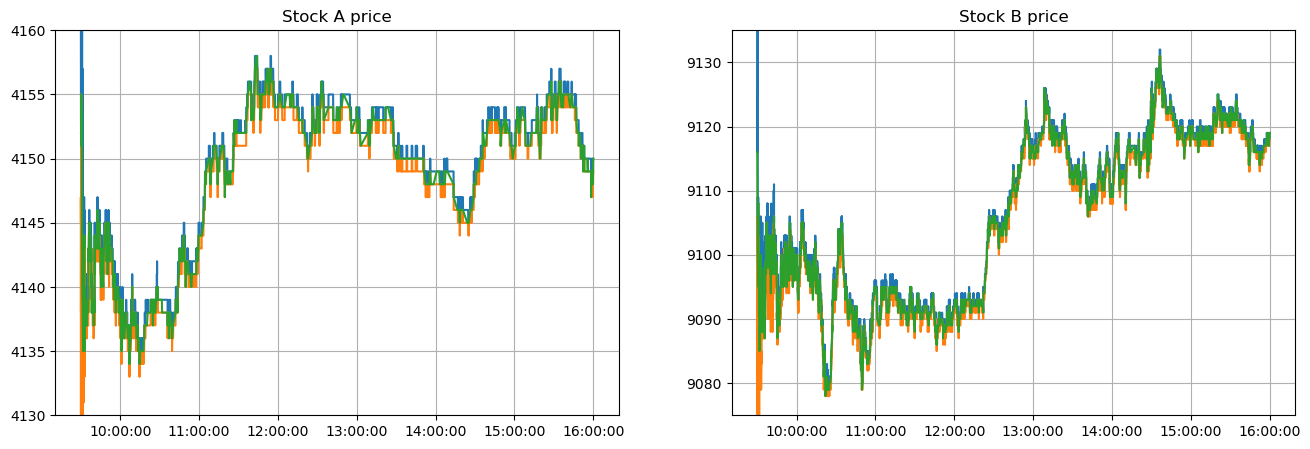

In [12]:
figure(figsize=(16,5))
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
ax1.plot(df_A_OrderBook['datetime'], df_A_OrderBook.ask)
ax1.plot(df_A_OrderBook['datetime'], df_A_OrderBook.bid)
ax1.plot(df_A_trade['datetime'], df_A_trade.trdpx)

ax1.set_title("Stock A price");ax1.grid(); ax1.set_ylim(4130,4160)
ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M:%S'))
ax2.plot(df_B_OrderBook['datetime'], df_B_OrderBook.ask)
ax2.plot(df_B_OrderBook['datetime'], df_B_OrderBook.bid)
ax2.plot(df_B_trade['datetime'], df_B_trade.trdpx)

ax2.set_title("Stock B price");ax2.grid(); ax2.set_ylim(9075, 9135)
ax2.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M:%S'))

<Figure size 1600x500 with 0 Axes>

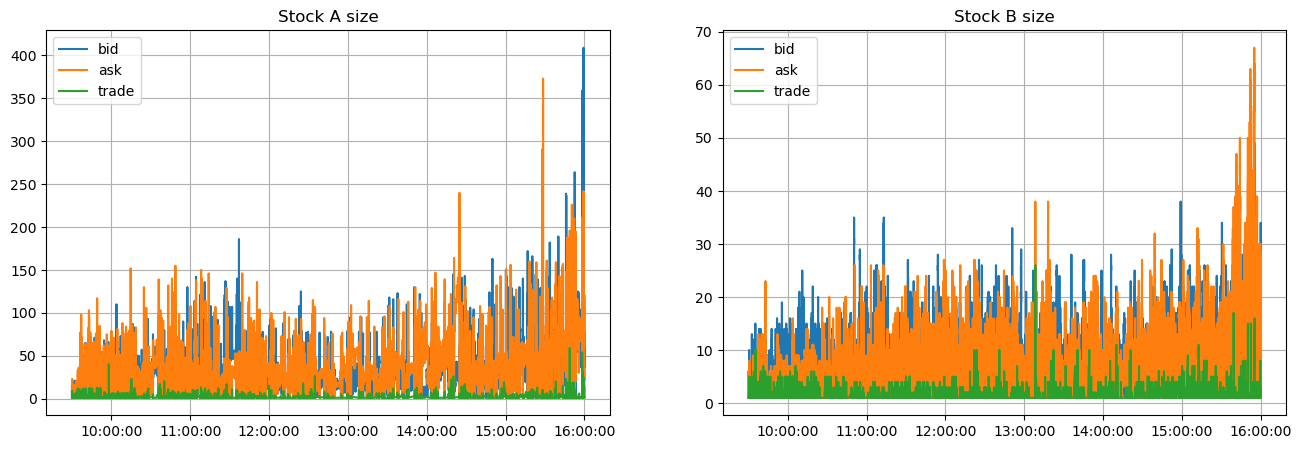

In [13]:
figure(figsize=(16,5))
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
ax1.plot(df_A_OrderBook['datetime'], df_A_OrderBook.bidsz,label = "bid")
ax1.plot(df_A_OrderBook['datetime'], df_A_OrderBook.asksz,label = "ask")
ax1.plot(df_A_trade['datetime'], df_A_trade.trdsz,label = "trade")
ax1.set_title("Stock A size");ax1.grid();ax1.legend()
ax1.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M:%S'))
ax2.plot(df_B_OrderBook['datetime'], df_B_OrderBook.bidsz,label = "bid")
ax2.plot(df_B_OrderBook['datetime'], df_B_OrderBook.asksz,label = "ask")
ax2.plot(df_B_trade['datetime'], df_B_trade.trdsz,label = "trade")
ax2.set_title("Stock B size");ax2.grid();ax2.legend()
ax2.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M:%S'))

Market has high volatility near the beginning. Stock B appears to have more price movements than stock A. 

In [14]:
pd.set_option('expand_frame_repr', False)
for df_i in [df_A_OrderBook,df_B_OrderBook,df_A_trade,df_B_trade]:
    print(df_i.describe())

               time            bid          bidsz            ask          asksz     trdsz     trdsd     trdpx        time_id
count  2.248020e+05  224802.000000  224802.000000  224802.000000  224802.000000  224802.0  224802.0  224802.0  224802.000000
mean   1.212839e+10    4146.824704      35.364085    4148.250038      38.667610       0.0       0.0       0.0   10327.873191
std    7.526593e+09       6.822445      29.260169       6.334418      27.714818       0.0       0.0       0.0    7526.589060
min    1.800101e+09    4006.000000       1.000000    4134.000000       1.000000       0.0       0.0       0.0       0.000000
25%    5.046605e+09    4141.000000      16.000000    4143.000000      20.000000       0.0       0.0       0.0    3246.250000
50%    1.046093e+10    4149.000000      28.000000    4150.000000      33.000000       0.0       0.0       0.0    8660.000000
75%    1.924920e+10    4152.000000      46.000000    4154.000000      50.000000       0.0       0.0       0.0   17449.000000


The size data is heavytailed. The maximum bidsz/asksz/trdsz is many stds above the mean. 

# Feature Engineerin

In [15]:
import warnings
warnings.filterwarnings('ignore')

### Single Stock Features

In [16]:
def calc_wap1(df):
    # Micropx
    wap = (df['bid'] * df['asksz'] + df['ask'] * df['bidsz']) / (df['bidsz'] + df['asksz'])
    return wap

def calc_wap2(df):
    # Volume weighted price
    wap = (df['bid'] * df['bidsz'] + df['ask'] * df['asksz']) / (df['bidsz'] + df['asksz'])
    return wap

def log_return(series):
    return np.log(series).diff()

def future_log_return(series, fwd_t):
    rtn = np.log(series).diff(fwd_t)
    return rtn.shift(-1*fwd_t)

def realized_volatility(series):
    return np.sqrt(np.sum(series**2))


In [17]:
def book_preprocessor(df):
    '''
    Function to preprocess book data
    '''
    # Change of data
    df['log_bidsz'] = log_return(df['bidsz'])
    df['log_asksz'] = log_return(df['asksz'])
    df['log_bid'] = log_return(df['bid'])
    df['log_ask'] = log_return(df['ask'])
    # Weighted average
    df['wap1'] = calc_wap1(df)
    df['wap2'] = calc_wap2(df)
    df['mid_price'] = (df['bid']+df['ask'])/2
 
    df['log_return1'] = log_return(df['wap1'])
    df['log_return2'] = log_return(df['wap2'])
    df['log_return'] = log_return(df['mid_price'])
    
    # Spread and imbalance
    df['price_spread'] = 2* (df['ask'] - df['bid']) / (df['ask'] + df['bid'])
    df['total_volume'] = df['asksz']  + df['bidsz'] 
    df['volume_imbalance'] = 2* (df['asksz'] - df['bidsz'])/(df['total_volume']) 
    
    create_feature_dict = {
        'wap1': [np.mean, np.std],
        'wap2': [np.mean, np.std],
        'mid_price':[np.mean, np.std],
        'price_spread':[np.mean, np.max],
        'total_volume':[np.sum, np.max],
        'volume_imbalance':[np.mean, np.max],
        'log_bidsz': [np.sum, realized_volatility],
        'log_asksz': [np.sum, realized_volatility],
        'log_bid': [np.sum, realized_volatility],
        'log_ask': [np.sum, realized_volatility],
        'log_return1': [np.sum, realized_volatility],
        'log_return2': [np.sum, realized_volatility],
        'log_return': [np.sum, realized_volatility],
    }
    
    df_feature = df.groupby(['time_id']).agg(create_feature_dict).reset_index()
    
    return df_feature

In [49]:
df_A_order_factors = book_preprocessor(df_A_OrderBook)
df_B_order_factors = book_preprocessor(df_B_OrderBook)

In [31]:
def trade_preprocessor(df):
    '''
    Function to preprocess trade data
    '''
    df['log_trdpx'] = df.groupby('time_id')['trdpx'].apply(log_return) 
    
    df['amount']= df['trdpx']*df['trdsz']

    create_feature_dict = {
        'log_trdpx':[realized_volatility],
        'trdsz':[np.sum, np.max, np.min],
        'amount':[np.sum, np.max,np.min],
    }
   
    df_feature = df.groupby(['time_id']).agg(create_feature_dict).reset_index()
    
    def impact(price, vol):    
        df_diff = np.diff(price)
        val = (df_diff/price[1:])*100
        power = np.sum(val*vol[1:])
        return(power)
    
    
    def cal_df_id_features(df_id):
        impactV = impact(df_id['trdpx'].values, df_id['trdsz'].values)      
        p_max = (df_id['trdpx'].values > df_id['trdpx'].mean()).mean()
        p_min =  (df_id['trdpx'].values < df_id['trdpx'].mean()).mean()
        df_min = (df_id['trdpx'].diff().dropna() < 0).mean()
        
        abs_diff = (df_id['trdpx'] - df_id['trdpx'].mean()).abs().median()
        energy = (df_id['trdpx']**2).mean()
        try:
            iqr_p = np.percentile(df_id['trdpx'].values,75) - np.percentile(df_id['trdpx'].values,25)
        except:
            iqr_p = 0
        
        abs_diff_v = (df_id['trdsz'] - df_id['trdsz'].mean()).abs().median()   
        energy_v = np.sum(df_id['trdsz'].values**2)
        
        try:
            iqr_p_v = np.percentile(df_id['trdsz'].values,75) - np.percentile(df_id['trdsz'].values,25)
        except:
            iqr_p_v = 0
        
        return [impactV, p_max, p_min, df_min, abs_diff, energy, iqr_p, abs_diff_v, energy_v, iqr_p_v]
    
    
    lis = []
    
    target_feats = [ 'impact', 'p_max', 'p_min', 'df_min', 'abs_diff', 'energy', 'iqr_p', 'abs_diff_v', 'energy_v', 'iqr_p_v']
    
    for n_time_id in df['time_id'].unique():
        
        feats_dict = dict()
        feats_dict['time_id'] = n_time_id
        
        df_id = df[df['time_id'] == n_time_id] 
        df_id_bid = df_id[df_id['trdsd'] == 1]
        df_id_ask = df_id[df_id['trdsd'] == -1]
        
        feats_dict['count_ratio'] = (len(df_id_bid) - len(df_id_ask))/len(df_id)
        feats_dict['vol_ratio'] = (df_id_bid['trdsz'].sum() - df_id_ask['trdsz'].sum())/(df_id_bid['trdsz'].sum()+ df_id_ask['trdsz'].sum())
        feats_dict['amount_ratio'] = (df_id_bid['amount'].sum() - df_id_ask['amount'].sum())/(df_id_bid['amount'].sum()+ df_id_ask['amount'].sum())
        
        feats_list_raw = cal_df_id_features(df_id)
        for i in range(len(target_feats)):
            feats_dict[target_feats[i]] = feats_list_raw[i]
        
        if len(df_id_bid):
            feats_list_bid = cal_df_id_features(df_id_bid)
            for i in range(len(target_feats)):
                feats_dict[target_feats[i] + '_bid'] = feats_list_bid[i]
        
        if len(df_id_bid):
            feats_list_ask = cal_df_id_features(df_id_ask)
            for i in range(len(target_feats)):
                feats_dict[target_feats[i] + '_ask'] = feats_list_ask[i]
        
        lis.append(feats_dict)
    
    df_lr = pd.DataFrame(lis)
        
    df_feature = df_feature.merge(df_lr, how = 'left', left_on = 'time_id', right_on = 'time_id')
    return df_feature

In [48]:
df_A_trade_factors = trade_preprocessor(df_A_trade).drop(columns='time_id')
df_B_trade_factors = trade_preprocessor(df_B_trade).drop(columns='time_id')

In [33]:
def conver_multiindex(df, df_name):
    new_index = ['time_id']
    for col in df.columns.values:
        if col=='time_id' or col[0]=='time_id':
            continue
        if isinstance(col, tuple):
            new_index.append('_'.join(col)+"_"+df_name)
        else:
            new_index.append(col+"_"+df_name)
    
    df.columns = new_index
    return df, new_index

In [50]:
df_A_order_factors, a_order_cols = conver_multiindex(df_A_order_factors, 'a')
df_B_order_factors, b_order_cols = conver_multiindex(df_B_order_factors, 'b')
df_A_trade_factors, a_trade_cols = conver_multiindex(df_A_trade_factors, 'a')
df_B_trade_factors, b_trade_cols = conver_multiindex(df_B_trade_factors, 'b')

merge_df = pd.merge(df_A_order_factors, df_B_order_factors, on='time_id', how='outer')
merge_df = pd.merge(merge_df, df_A_trade_factors, on='time_id', how='outer')
merge_df = pd.merge(merge_df, df_B_trade_factors, on='time_id', how='outer')
merge_df = merge_df.sort_values(by='time_id').reset_index(drop=True)
merge_df.ffill(inplace=True)
merge_df.fillna(value=0, inplace=True)

### Normalization

In [55]:
def rw_stand(series):
    '''rolling_window_standardize'''
    mean_20 = series.ewm(span=20, adjust=False).mean()
    std_20 = series.ewm(span=20, adjust=False).std()

    standardized_s = (series - mean_20) / std_20
    return standardized_s

In [56]:
rw_target_cols = ['wap1_mean_a', 'wap2_mean_a', 'wap1_mean_b', 'wap2_mean_b','mid_price_mean_a','mid_price_mean_b']

In [57]:
for col in rw_target_cols:
    merge_df['rw_'+col] = rw_stand(merge_df[col])
merge_df.fillna(0, inplace=True)

### Correlated Features and Time Series Features

The prediction is log return of the mid price, at one second horizon.

In [61]:
y_a = merge_df['log_return_sum_a']
y_b = merge_df['log_return_sum_b']

Text(0.5, 0, 'Seconds')

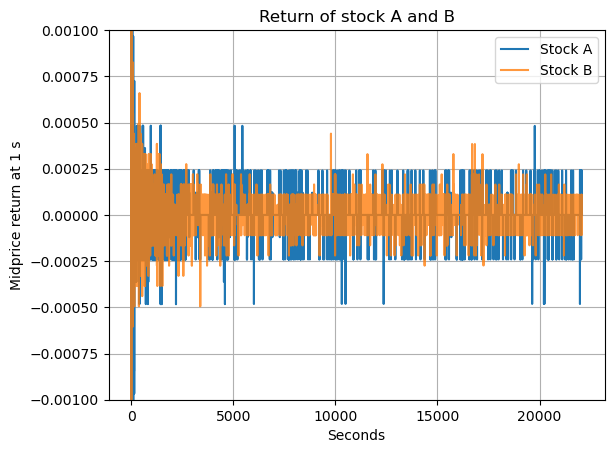

In [91]:
plot(y_a, label="Stock A", alpha =1)
plot(y_b, label="Stock B", alpha =0.8)
ylim(-0.001,0.001)
legend();grid()
title("Return of stock A and B")
ylabel("Midprice return at 1 s")
xlabel("Seconds")

Text(0, 0.5, 'Correlation')

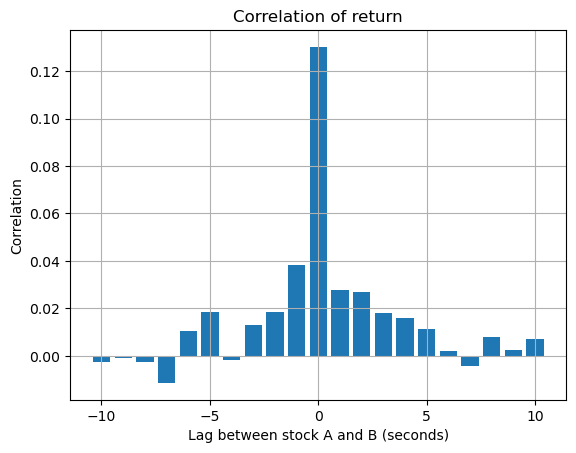

In [100]:
corr_list = []
for i in range(-10,0):
    corr_list.append(np.corrcoef(y_a[1800:i], y_b.shift(i)[1800:i])[0,1])
for i in range(11):
    corr_list.append(np.corrcoef(y_a[1800+i:], y_b.shift(i)[1800+i:])[0,1])
bar(np.arange(-10,11),corr_list)
grid()
title("Correlation of return")
xlabel("Lag between stock A and B (seconds)")
ylabel("Correlation")

From this plot, the return of stock A and B are indeed correlated to each other. Therefore, we can use the return of A as our predictor for the return of B and vice versa.

In [103]:
target_cols = ['rw_wap1_mean', 'rw_wap2_mean',
               'log_return1_sum', 'log_return2_sum', 'price_spread_amax', 'price_spread_mean',
              'abs_diff','energy','iqr_p','abs_diff_v','energy_v','iqr_p_v']

diff_target_cols = ['diff_' +col for col in target_cols]
for col in target_cols:
    assert col+'_a' in merge_df.columns, col+'_a'

In [104]:
for col in target_cols:
    if col+'_a' not in merge_df:print(col)

In [105]:
def cal_all_difference_features(df, target_cols):
    for col in target_cols:
        df['diff_'+col] = df[col+'_a'] - df[col+'_b']
    return df

In [106]:
merge_df = cal_all_difference_features(merge_df, target_cols)

In [210]:
merge_df.fillna(0,inplace=True)

# Modeling

In [296]:
from sklearn.preprocessing import StandardScaler

In [297]:
X = merge_df.iloc[2000:-1, 1:]
y_a = merge_df['log_return_sum_a'].shift(-1)[2000:-1]
y_b = merge_df['log_return_sum_b'].shift(-1)[2000:-1]

scaler = StandardScaler()
scaler.fit(X)
norm_X = scaler.transform(X)

In [298]:
X.shape

(20073, 156)

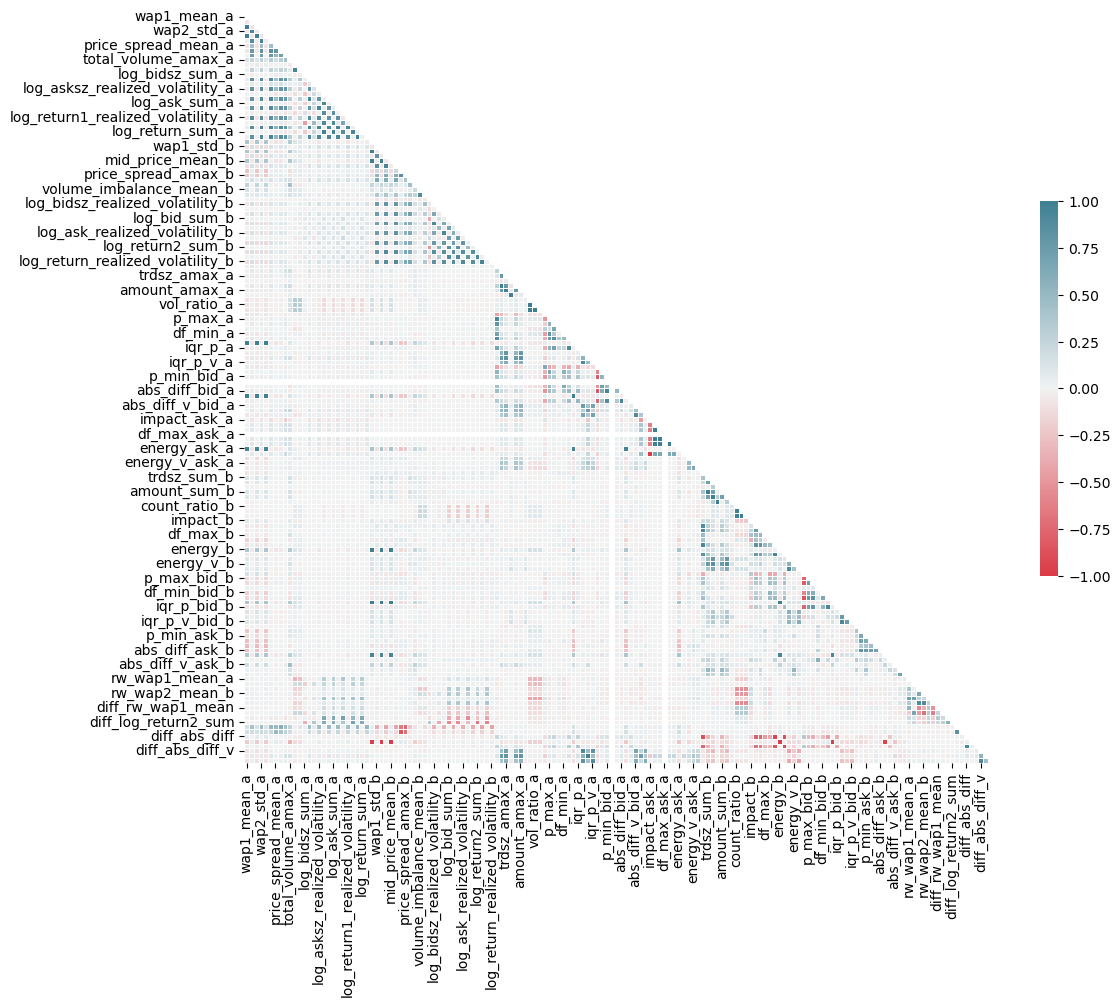

In [299]:
import seaborn as sns

mask = np.triu(np.ones_like(X.corr(), dtype=np.bool))
fig, ax = plt.subplots(figsize=(12, 10))
cmap = sns.diverging_palette(10, 220, as_cmap=True)

sns.heatmap(X.corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
fig.tight_layout()

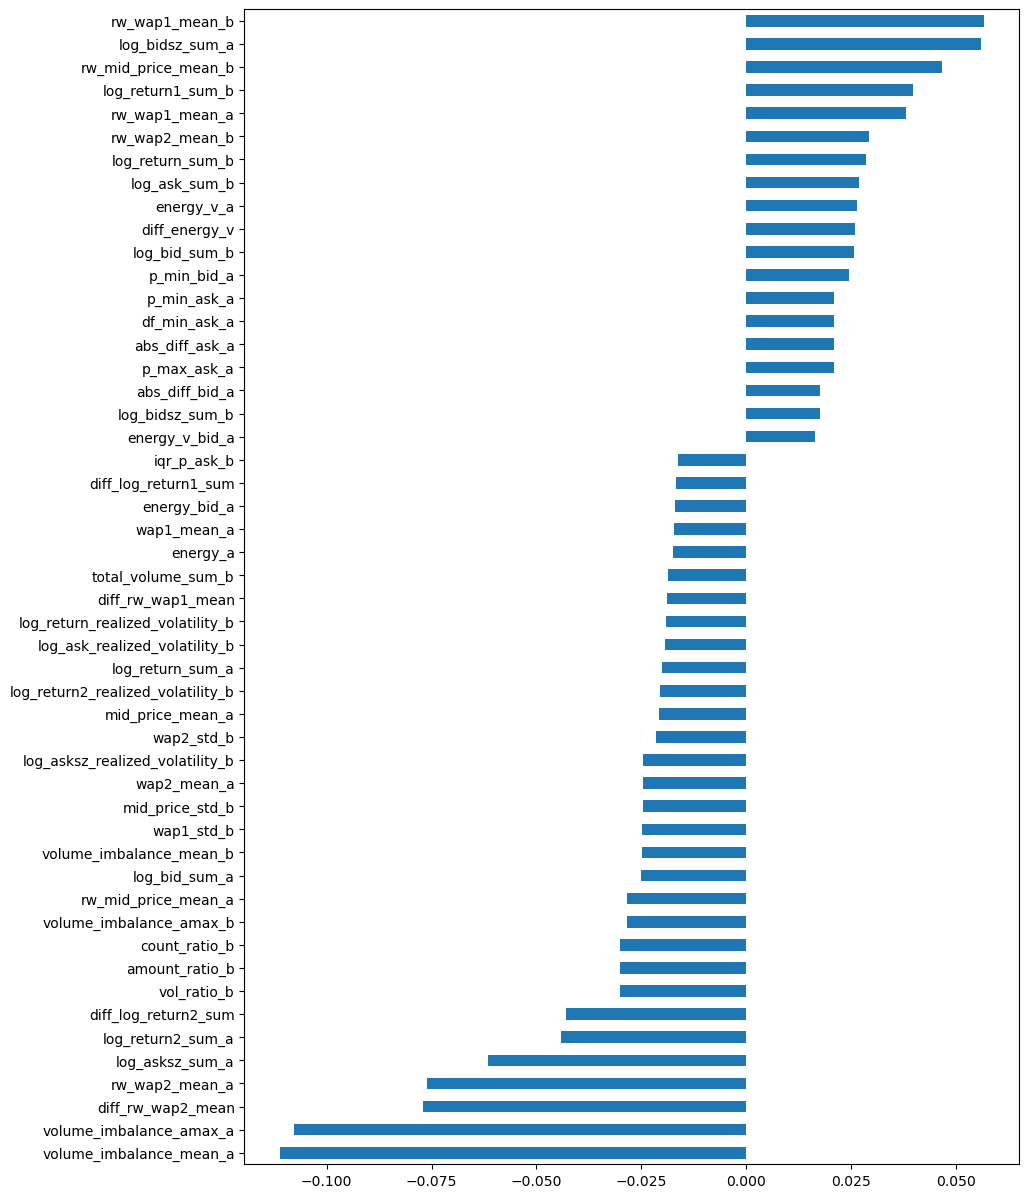

In [319]:
fwd_corr = merge_df.corrwith(y_a)

top50 = fwd_corr.abs().nlargest(50).index
fwd_corr.loc[top50].sort_values().plot.barh(figsize=(10, 15),
                                            legend=False);

## Linear Model

In [300]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

Use rolling window to conduct training. Since we have 156 features, if we choose a data-to-feature ratio of 20, we should have 3000 training data at least. Therefore, we will pick a window of training size 3200 and testing size 800, and roll at a step of 800.

In [322]:
window_size = 4000

r2_list_Lasso_a = []
r2_list_Ridge_a = []
r2_list_Lasso_b = []
r2_list_Ridge_b = []
for i in range(0,len(X)-window_size,800):  
    X_train, X_test, y_train, y_test = train_test_split(X[top50][i:i+window_size], y_a[i:i+window_size], test_size=0.2, shuffle = False)
    model = LassoCV()
    model.fit(X_train, y_train)
    r2_list_Lasso_a.append(r2_score(y_test, model.predict(X_test)))
    model = RidgeCV()
    model.fit(X_train, y_train)
    r2_list_Ridge_a.append(r2_score(y_test, model.predict(X_test)))

    X_train, X_test, y_train, y_test = train_test_split(X[top50][i:i+window_size], y_b[i:i+window_size], test_size=0.2, shuffle = False)
    model = LassoCV()
    model.fit(X_train, y_train)
    r2_list_Lasso_b.append(r2_score(y_test, model.predict(X_test)))
    model = RidgeCV()
    model.fit(X_train, y_train)
    r2_list_Ridge_b.append(r2_score(y_test, model.predict(X_test)))

Text(0.5, 1.0, 'Stock B')

<Figure size 1600x500 with 0 Axes>

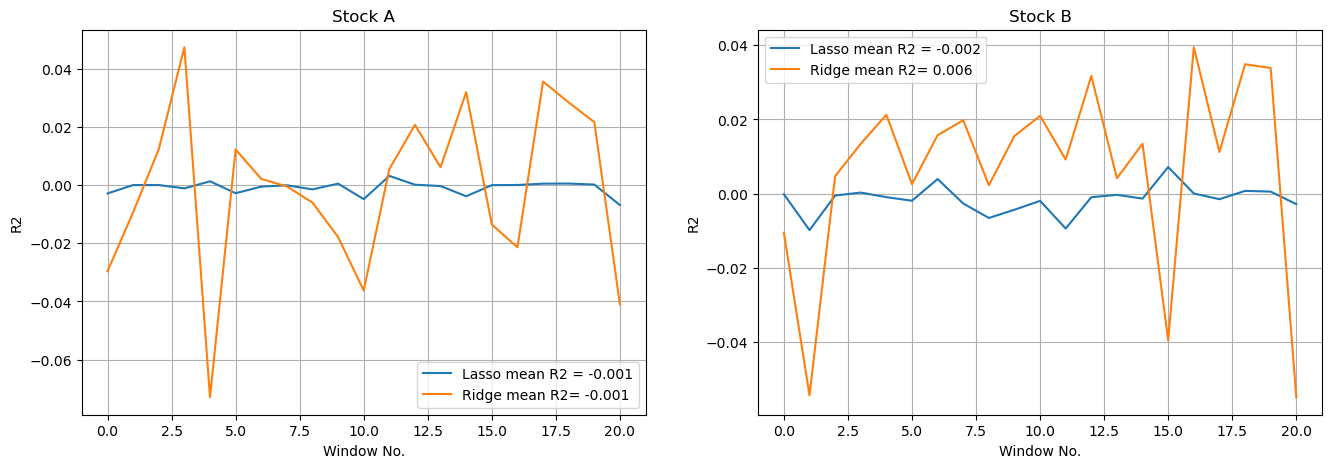

In [323]:
figure(figsize=(16,5))
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
ax1.plot(r2_list_Lasso_a, label=f"Lasso mean R2 = {np.mean(r2_list_Lasso_a):.3f}")
ax1.plot(r2_list_Ridge_a, label=f"Ridge mean R2= {np.mean(r2_list_Ridge_a):.3f}")
ax1.grid();ax1.legend();ax1.set_xlabel("Window No.");ax1.set_ylabel("R2");ax1.set_title("Stock A")
ax2.plot(r2_list_Lasso_b, label=f"Lasso mean R2 = {np.mean(r2_list_Lasso_b):.3f}")
ax2.plot(r2_list_Ridge_b, label=f"Ridge mean R2= {np.mean(r2_list_Ridge_b):.3f}")
ax2.grid();ax2.legend();ax2.set_xlabel("Window No.");ax2.set_ylabel("R2");ax2.set_title("Stock B")

Linear Model does not perform very well.

## Nonlinear Model

In [303]:
import xgboost
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

Though we should still use a rolling window for testing, it is safer to give nonlinear model more data. Therefore, I will simply reserve the last 20% of data as testing data.

In [316]:
X_train, X_test, y_train, y_test = train_test_split(X, y_b, test_size=0.2, shuffle = True)

In [317]:
xgb_model = xgboost.XGBRegressor()

gird_search_params =  {
    "max_depth": [ 6, 8, 10], 
    "n_estimators": [10, 30, 50],
    'learning_rate':[ 0.05,],
    'alpha':[0.1,0.5,1],   # L1
    'lambda':[0.1,0.5, 1],   # L2
}

clf = RandomizedSearchCV(
    xgb_model,
   gird_search_params,
    n_jobs=-1,
    cv=5)

clf.fit(X_train, y_train)
clf.best_params_

{'n_estimators': 50,
 'max_depth': 6,
 'learning_rate': 0.05,
 'lambda': 1,
 'alpha': 1}

In [318]:
xgb_best_model = clf.best_estimator_
print(r2_score(y_test, xgb_best_model.predict(X_test)))

-0.0003150854567743888
